<a href="https://colab.research.google.com/github/IzaakGagnon/Integrated_Information_Testing/blob/main/Test_code/Persistent_Homology_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install ripser persim matplotlib


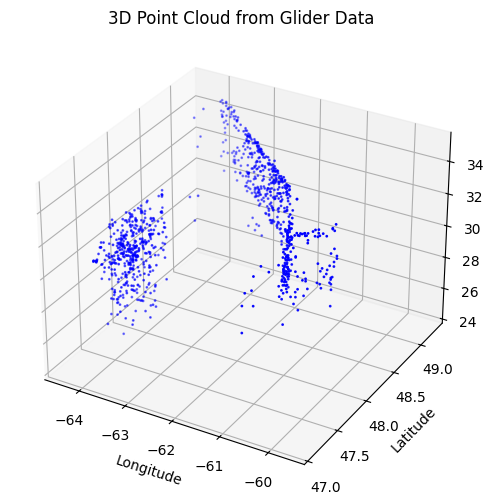

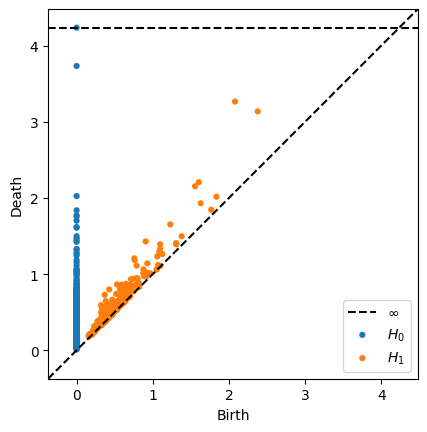

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser
from persim import plot_diagrams

# Step 1: Load the glider data
df = pd.read_hdf('/content/drive/MyDrive/Glider data/glider_data.h5')
df = df.sample(n=1000, random_state=42)
# Step 2: Drop any rows with missing spatial coordinates
df = df.dropna(subset=['longitude', 'latitude', 'depth'])
# Use all *non-target* variables to create a point cloud in high-D space
features = ['longitude', 'latitude', 'salinity', 'temperature', 'density']
points = df[features].dropna().values
# Optional: Subsample to reduce computation time (if you have a huge dataset)
# points = points[np.random.choice(points.shape[0], 1000, replace=False)]

# Step 4: Compute persistent homology
result = ripser(points)
diagrams = result['dgms']

# Step 5: Plot the 3D point cloud
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='blue')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
ax.set_title('3D Point Cloud from Glider Data')
plt.show()

# Step 6: Plot the persistence diagram
plot_diagrams(diagrams, show=True)


In [24]:
# Count H₀ components with persistence (death - birth) > threshold
persistence_threshold = 2
persistent_components = [pt for pt in diagrams[0] if pt[1] - pt[0] > persistence_threshold]
print("Persistent components (H₀, lifetime > 0.95):", len(persistent_components))


Persistent components (H₀, lifetime > 0.95): 3


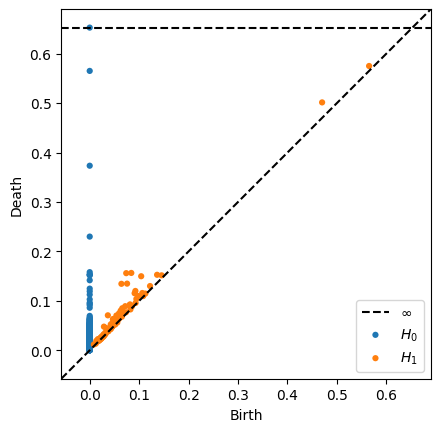

Chosen connectivity threshold (epsilon): 0.1
Number of persistent connected components at epsilon = 0.1 : 13


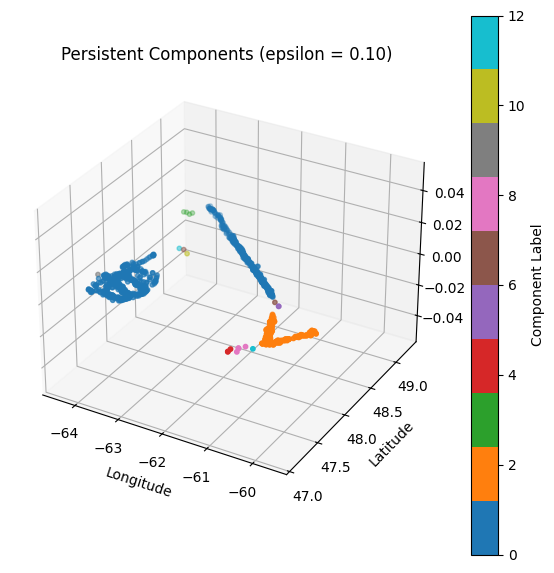

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import pdist, squareform
import networkx as nx

# Step 1: Load the glider data and subsample for speed
df = pd.read_hdf('/content/drive/MyDrive/Glider data/glider_data.h5')
df = df.dropna(subset=['longitude', 'latitude', 'depth'])
df = df.sample(n=10000, random_state=42)

# Build the point cloud using spatial coordinates;
# you could later include more features (after scaling) if desired.
points = df[['longitude', 'latitude']].values

# Step 2: Compute persistent homology using Ripser
result = ripser(points)
diagrams = result['dgms']

# Plot the persistence diagram for H0 (connected components)
plot_diagrams(diagrams, show=True)

# Step 3: Use persistent homology to choose a threshold.
# For H0, all features are born at 0. We ignore the one that persists forever.
h0 = diagrams[0]
# Filter out the infinite death (often represented by np.inf)
finite_deaths = h0[np.isfinite(h0[:, 1]), 1]
if len(finite_deaths) == 0:
    raise ValueError("No finite death values found in H0 diagram!")
# As an example, we choose the median finite death value as the connectivity threshold.
threshold = 0.1
print("Chosen connectivity threshold (epsilon):", threshold)

# Step 4: Build a graph using this threshold.
# Two points are connected if their Euclidean distance is less than the threshold.
dist_matrix = squareform(pdist(points))
G = nx.Graph()
n_points = len(points)
G.add_nodes_from(range(n_points))
for i in range(n_points):
    for j in range(i+1, n_points):
        if dist_matrix[i, j] <= threshold:
            G.add_edge(i, j)

# Extract connected components from the graph.
components = list(nx.connected_components(G))
print("Number of persistent connected components at epsilon =", threshold, ":", len(components))

# Assign a cluster label to each point based on its component.
labels = np.empty(n_points, dtype=int)
for label, comp in enumerate(components):
    for idx in comp:
        labels[idx] = label

# Step 5: Plot the 3D point cloud with points colored by their component label.
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(points[:, 0], points[:, 1], c=labels, cmap='tab10', s=10)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Persistent Components (epsilon = {threshold:.2f})')
plt.colorbar(scatter, ax=ax, label='Component Label')
plt.show()


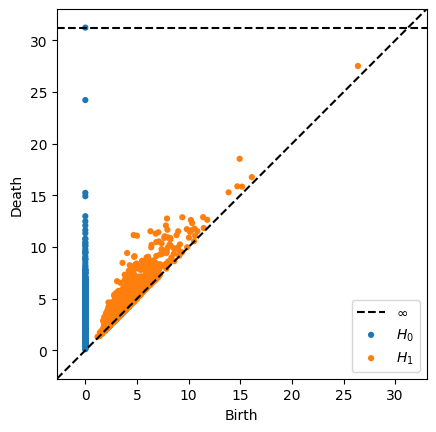

Chosen connectivity threshold (epsilon): 5
Number of persistent connected components at epsilon = 5 : 152


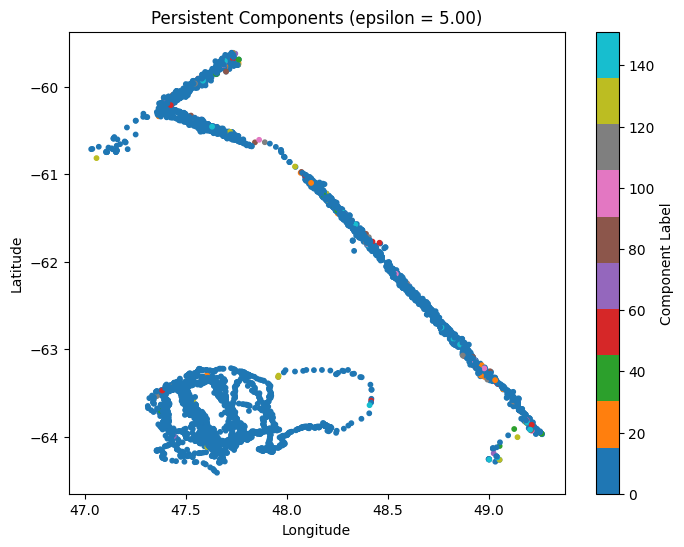

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import pdist, squareform
import networkx as nx

# Step 1: Load the glider data and subsample for speed
df = pd.read_hdf('/content/drive/MyDrive/Glider data/glider_data.h5')
df = df.dropna()  # drop rows with any missing values
if 'time' in df.columns:
    df = df.drop(columns=['time'])

# Optionally subsample for speed:
df = df.sample(n=5000, random_state=42)

# Build the point cloud
points = df.values

# Step 2: Compute persistent homology using Ripser
result = ripser(points)
diagrams = result['dgms']

# Plot the persistence diagram for H0 (connected components)
plot_diagrams(diagrams, show=True)

# Step 3: Use persistent homology to choose a threshold.
# For H0, all features are born at 0; we ignore the infinite death value.
h0 = diagrams[0]
finite_deaths = h0[np.isfinite(h0[:, 1]), 1]
if len(finite_deaths) == 0:
    raise ValueError("No finite death values found in H0 diagram!")
# Here, we set the threshold manually to 0.1 (adjust as needed)
threshold = 5
print("Chosen connectivity threshold (epsilon):", threshold)

# Step 4: Build a graph using this threshold.
# Connect two points if their Euclidean distance is less than the threshold.
dist_matrix = squareform(pdist(points))
G = nx.Graph()
n_points = len(points)
G.add_nodes_from(range(n_points))
for i in range(n_points):
    for j in range(i+1, n_points):
        if dist_matrix[i, j] <= threshold:
            G.add_edge(i, j)

# Extract connected components from the graph.
components = list(nx.connected_components(G))
print("Number of persistent connected components at epsilon =", threshold, ":", len(components))

# Assign a cluster label to each point based on its component.
labels = np.empty(n_points, dtype=int)
for label, comp in enumerate(components):
    for idx in comp:
        labels[idx] = label

# Step 5: Plot the 2D scatter plot with points colored by their component label.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='tab10', s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Persistent Components (epsilon = {threshold:.2f})')
plt.colorbar(scatter, label='Component Label')
plt.show()

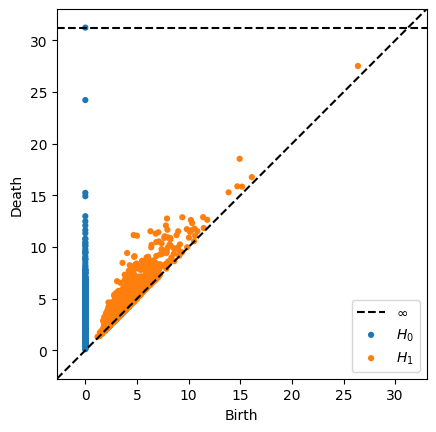

Chosen connectivity threshold (epsilon): 10.5
Number of persistent connected components at epsilon = 10.5 : 11


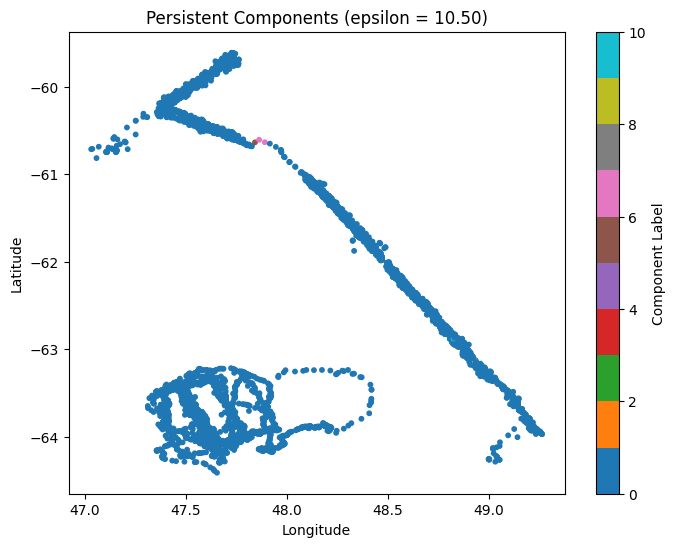

In [14]:

# Plot the persistence diagram for H0 (connected components)
plot_diagrams(diagrams, show=True)

# Step 3: Use persistent homology to choose a threshold.
# For H0, all features are born at 0; we ignore the infinite death value.
h0 = diagrams[0]
finite_deaths = h0[np.isfinite(h0[:, 1]), 1]
if len(finite_deaths) == 0:
    raise ValueError("No finite death values found in H0 diagram!")
# Here, we set the threshold manually to 0.05 (adjust as needed)
threshold = 10.5
print("Chosen connectivity threshold (epsilon):", threshold)

# Step 4: Build a graph using this threshold.
# Connect two points if their Euclidean distance is less than the threshold.
dist_matrix = squareform(pdist(points))
G = nx.Graph()
n_points = len(points)
G.add_nodes_from(range(n_points))
for i in range(n_points):
    for j in range(i+1, n_points):
        if dist_matrix[i, j] <= threshold:
            G.add_edge(i, j)

# Extract connected components from the graph.
components = list(nx.connected_components(G))
print("Number of persistent connected components at epsilon =", threshold, ":", len(components))

# Assign a cluster label to each point based on its component.
labels = np.empty(n_points, dtype=int)
for label, comp in enumerate(components):
    for idx in comp:
        labels[idx] = label

# Step 5: Plot the 2D scatter plot with points colored by their component label.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='tab10', s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Persistent Components (epsilon = {threshold:.2f})')
plt.colorbar(scatter, label='Component Label')
plt.show()

Chosen connectivity threshold (epsilon): 8
Number of persistent connected components at epsilon = 8 : 27


<ipython-input-19-6ac65240a8f4>:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', len(unique_labels))


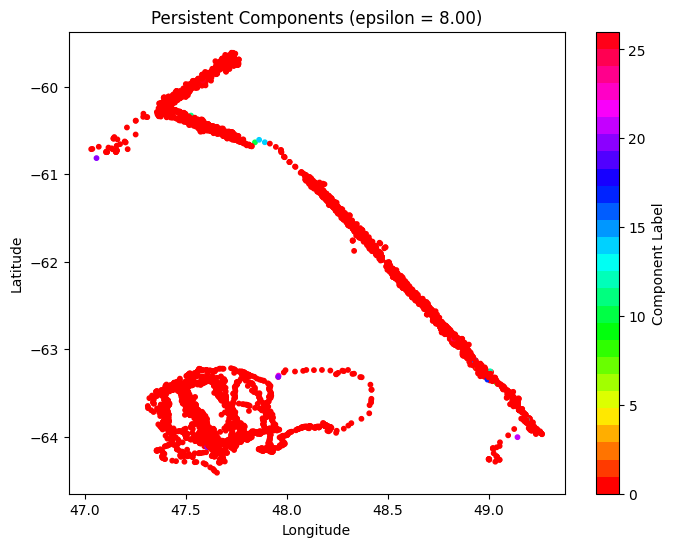

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [19]:

# Step 3: Choose a connectivity threshold (manually, informed by the persistence diagram).
# Here, we set the threshold to 10.5 (adjust this value as needed).
threshold = 8
print("Chosen connectivity threshold (epsilon):", threshold)

# Step 4: Build a graph where an edge exists if the Euclidean distance between two points is <= threshold.
dist_matrix = squareform(pdist(points))
n_points = len(points)
G = nx.Graph()
G.add_nodes_from(range(n_points))
for i in range(n_points):
    for j in range(i+1, n_points):
        if dist_matrix[i, j] <= threshold:
            G.add_edge(i, j)

# Extract connected components from the graph.
components = list(nx.connected_components(G))
print("Number of persistent connected components at epsilon =", threshold, ":", len(components))

# Assign a cluster label to each point based on its connected component.
labels = np.empty(n_points, dtype=int)
for comp_label, comp in enumerate(components):
    for idx in comp:
        labels[idx] = comp_label

# Step 5: Plot the 2D scatter plot (Longitude vs. Latitude) with points colored by their component label.
# Create a discrete colormap with enough colors.
unique_labels = np.unique(labels)
# Here we use 'tab20' if there are <=20 clusters; otherwise, use 'hsv' for a continuous hue.
if len(unique_labels) <= 20:
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))
else:
    cmap = plt.cm.get_cmap('hsv', len(unique_labels))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(points[:, 0], points[:, 1], c=labels, cmap=cmap, s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Persistent Components (epsilon = {threshold:.2f})')
plt.colorbar(scatter, label='Component Label')
plt.show()
unique_labels

Number of persistent connected components at epsilon = 8 : 27


<ipython-input-20-4e358211488a>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('hsv', len(unique_labels))


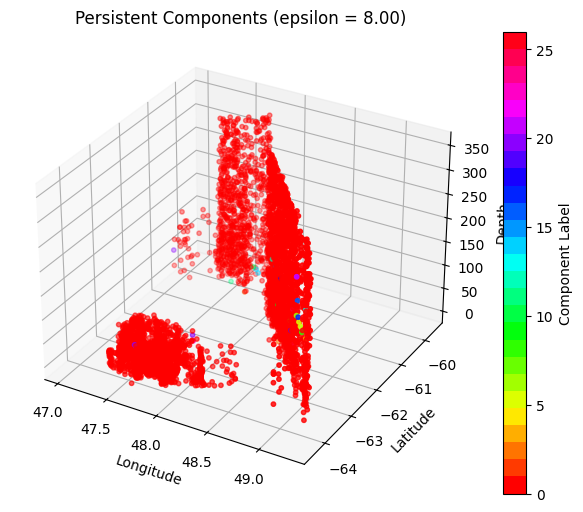

In [20]:
# Step 4: Build a graph where an edge exists if the Euclidean distance between two points is <= threshold.
dist_matrix = squareform(pdist(points))
n_points = len(points)
G = nx.Graph()
G.add_nodes_from(range(n_points))
for i in range(n_points):
    for j in range(i+1, n_points):
        if dist_matrix[i, j] <= threshold:
            G.add_edge(i, j)

# Extract connected components from the graph.
components = list(nx.connected_components(G))
print("Number of persistent connected components at epsilon =", threshold, ":", len(components))

# Assign a cluster label to each point based on its connected component.
labels = np.empty(n_points, dtype=int)
for comp_label, comp in enumerate(components):
    for idx in comp:
        labels[idx] = comp_label

# Step 5: Plot the 3D scatter plot (Longitude vs. Latitude vs. Depth) with points colored by their component label.
unique_labels = np.unique(labels)
# Use a discrete colormap: 'tab20' if there are <=20 clusters; otherwise, 'hsv'
if len(unique_labels) <= 20:
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))
else:
    cmap = plt.cm.get_cmap('hsv', len(unique_labels))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=labels, cmap=cmap, s=10)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
ax.set_title(f'Persistent Components (epsilon = {threshold:.2f})')
plt.colorbar(scatter, ax=ax, label='Component Label')
plt.show()

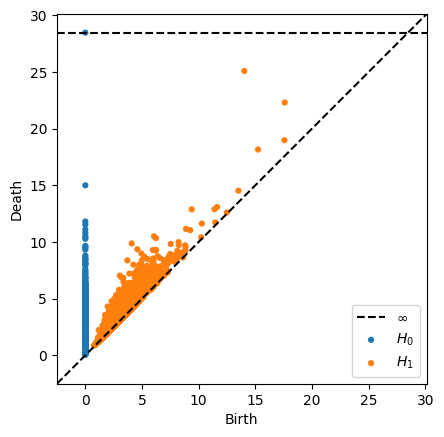

Chosen connectivity threshold (epsilon): 10.5
Number of connected components before splitting: 7
Number of components after splitting: 16


<ipython-input-21-d34049458227>:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


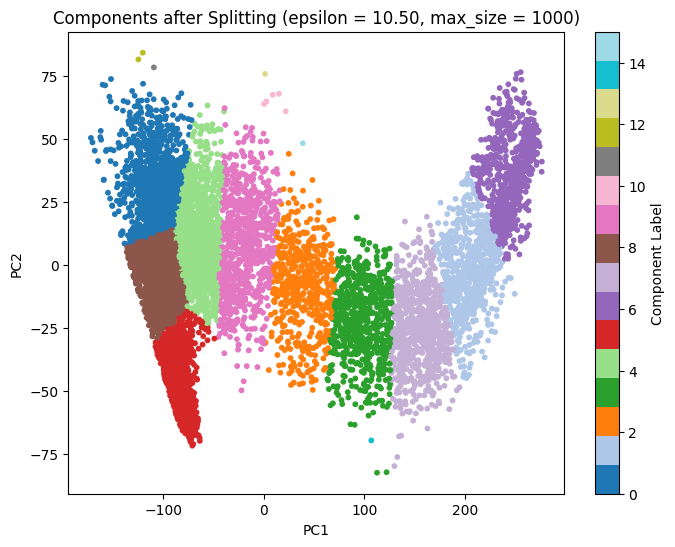

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import pdist, squareform
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# -------------------------------
# Step 1: Load and Prepare Data
# -------------------------------
# Load the glider data from the HDF5 file.
df = pd.read_hdf('/content/drive/MyDrive/Glider data/glider_data.h5')

# Drop any rows with missing values in any column.
df = df.dropna()

# Remove the "time" column if it exists.
df = df.drop(columns=['time'], errors='ignore')

# Subsample the data for speed.
df = df.sample(n=10000, random_state=42)

# Build the point cloud using all remaining columns.
# This results in a high-dimensional point cloud (e.g., longitude, latitude, depth, oxygen, salinity, density, temperature)
points = df.values

# -------------------------------
# Step 2: Compute Persistent Homology
# -------------------------------
result = ripser(points)
diagrams = result['dgms']

# Plot the persistence diagrams (you can inspect the H0 diagram to inform threshold choice)
plot_diagrams(diagrams, show=True)

# -------------------------------
# Step 3: Choose Connectivity Threshold
# -------------------------------
# Here, we set the threshold manually to 10.5 (adjust this value as needed)
threshold = 10.5
print("Chosen connectivity threshold (epsilon):", threshold)

# -------------------------------
# Step 4: Build Graph and Extract Components
# -------------------------------
# Compute pairwise distances between points.
dist_matrix = squareform(pdist(points))
n_points = len(points)

# Build an undirected graph where an edge connects two points if their distance is <= threshold.
G = nx.Graph()
G.add_nodes_from(range(n_points))
for i in range(n_points):
    for j in range(i+1, n_points):
        if dist_matrix[i, j] <= threshold:
            G.add_edge(i, j)

# Extract connected components from the graph.
components = list(nx.connected_components(G))
print("Number of connected components before splitting:", len(components))

# -------------------------------
# Step 5: Split Large Components
# -------------------------------
def split_large_component(component_indices, points, max_size):
    """
    Given a set of indices (component_indices) for a large connected component,
    split it into smaller clusters so that each resulting cluster has at most max_size points.
    """
    # Convert the set of indices to a NumPy array.
    component_indices = np.array(list(component_indices))
    num_points = len(component_indices)

    # Determine the number of clusters needed.
    n_clusters = int(np.ceil(num_points / max_size))

    # Extract the points corresponding to this component.
    component_points = points[component_indices]

    # Cluster these points using KMeans.
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    sub_labels = kmeans.fit_predict(component_points)

    # Create new clusters (as sets of original indices).
    new_clusters = []
    for cl in np.unique(sub_labels):
        indices = component_indices[sub_labels == cl]
        new_clusters.append(set(indices))
    return new_clusters

# Define maximum allowed size for a component.
max_size = 1000

# Process each component: if its size exceeds max_size, split it using KMeans.
new_components = []
for comp in components:
    if len(comp) > max_size:
        split_comps = split_large_component(comp, points, max_size)
        new_components.extend(split_comps)
    else:
        new_components.append(comp)

print("Number of components after splitting:", len(new_components))

# Assign a cluster label to each point based on the (possibly split) components.
labels = np.empty(n_points, dtype=int)
for label, comp in enumerate(new_components):
    for idx in comp:
        labels[idx] = label

# -------------------------------
# Step 6: Visualize via PCA Projection
# -------------------------------
# Since the point cloud is high-dimensional, we project it to 2D using PCA for visualization.
pca = PCA(n_components=2)
points_2d = pca.fit_transform(points)

# Choose a discrete colormap: if there are <=20 clusters, use 'tab20'; otherwise, use 'hsv'.
unique_labels = np.unique(labels)
if len(unique_labels) <= 20:
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))
else:
    cmap = plt.cm.get_cmap('hsv', len(unique_labels))

plt.figure(figsize=(8, 6))
scatter = plt.scatter(points_2d[:, 0], points_2d[:, 1], c=labels, cmap=cmap, s=10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Components after Splitting (epsilon = {threshold:.2f}, max_size = {max_size})')
plt.colorbar(scatter, label='Component Label')
plt.show()
